<a href="https://colab.research.google.com/github/bachaudhry/foundations_to_stable_diffusion/blob/main/simple_diffusion_audio_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generating Audio Samples Using Simple Diffusion**

Johnathan Whitaker's demo borrows heavily from the [Diffusion for Audio NB by HuggingFace](https://github.com/huggingface/diffusion-models-class/blob/main/unit4/02_diffusion_for_audio.ipynb).

Additionally, Johno also created the dataset used in this NB.

Diffusers Version 0.24.0 will be used given the Audio Diffusers pipeline has been deprecated [as highlighted here](https://github.com/huggingface/diffusers/pull/6169).

PyTorch recommends that we install `librosa` when attempting to use the MelSpectrogram.

In [1]:
!pip install -q miniminiai datasets torchaudio diffusers librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [41]:
import torch, random, os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
import torchaudio
import torchaudio.functional as AF
from torchaudio import transforms as AT
from torch.utils.data import default_collate
from torchvision.transforms import functional as TF
from huggingface_hub import hf_hub_download
from diffusers import DiffusionPipeline, AudioDiffusionPipeline, Mel

import fastcore.all as fc
from PIL import Image
from miniminiai import *
from functools import partial
from datasets import load_dataset
from IPython.display import Audio
from matplotlib import pyplot as plt

This is the inner working of the Mel Spectrogram which focuses on modelling the range of frequencies which the average human ear can pick up.

In [ ]:
# Implementing core Mel Spectrogram logic
class MelSpec:
  def __init__(self, sample_rate=16000, x_res=None, y_res=None,
               n_fft=1024, hop_length=512, f_min=0.0, fmax=None,
               slice_size=512):
    self.sample_rate = sample_rate
    self.x_res = x_res
    self.y_res = y_res
    self.n_fft = n_fft
    self.hop_length = hop_length
    self.f_min = f_min
    self.fmax = fmax
    self.slice_size = slice_size

    # Calculate hop_length and n_fft based on resolutions
    self.hop_length = (sample_rate * (self.x_res - 1) + self.n_fft) // self.x_res
    self.n_fft = self.hop_length * (self.x_res - 1) + 1

    self.mel_spectrogram = AT.MelSpectrogram(
        sample_rate=self.sample_rate,
        n_fft=self.n_fft,
        n_mels=self.y_res,
        hop_length=self.hop_length,
        f_min=self.f_min,
        f_max=self.fmax
    )

  def __call__(self, waveform):
    mel_spec = self.mel_spectrogram(waveform)
    mel_spec = torchaudio.functional.amplitude_to_db(mel_spec, top_db=80.0)
    return mel_spec

  def x_res(self, waveform_length):
    return 1 + (waveform_length - self.n_fft) // self.hop_length

  def y_res(self):
    return self.n_mels

The diagram can be found within [PyTorch's documentation for audio feature extraction](https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#melspectrogram). The diagram shows the relationship between common audio features and torchaudio's APIs to generate them

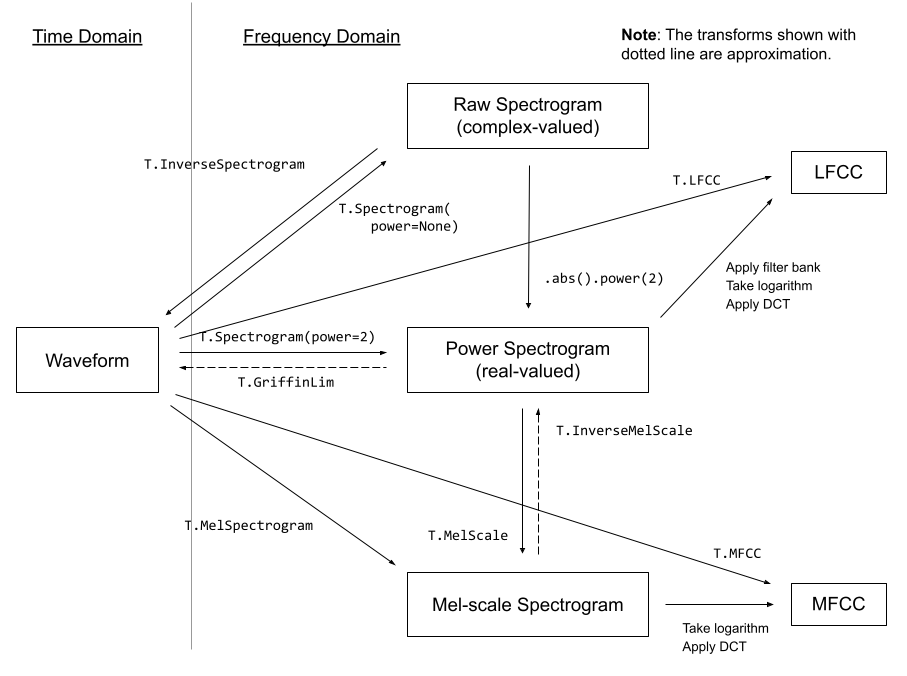

## **Load Audio Data**

In [4]:
# These settings are used for the Mel Spectrograms
sample_rate = 16000
x_res = 128 # x resolution of the spectrogram (time)
y_res = 128 # y resolution of the spectrogram (frequency - binned)
mel = Mel(x_res, y_res, sample_rate)

In [5]:
# Load the dataset of bird calls
birdcall_dataset = load_dataset("tglcourse/5s_birdcall_samples_top20")

README.md:   0%|          | 0.00/454 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/977 [00:00<?, ?B/s]

train-00000-of-00006.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

train-00001-of-00006.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

train-00002-of-00006.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

train-00003-of-00006.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

train-00004-of-00006.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

train-00005-of-00006.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9595 [00:00<?, ? examples/s]

In [6]:
birdcall_dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 9595
    })
})

In [7]:
birdcall_dataset['train'][0]

{'audio': {'path': None,
  'array': array([ 0.00588989, -0.00027466, -0.006073  , ..., -0.00396729,
         -0.00161743,  0.00228882]),
  'sampling_rate': 32000},
 'label': 'rewbla'}

The data has a sample rate of 32,000 bps which is a waveform and can be very challenging to model since there are 32,000 values per second represented as 1-D arrays.

Also, frequencies have very large variations in range and can be subject to very long range dependencies. Take, for example, a long violin chord which can last for seconds, which is comprised of multiple notes of varying frequencies and pitches and has varying volume - all depending on the artist's playing style. Thats ALOT of variation to capture on a second by second basis.

The workaround is to use a [spectrogram](https://musiclab.chromeexperiments.com/spectrogram/) to effectively convert audio data to visual data with time on the x-axis and frequencies on the y-axis, model it and then convert it back to the original waveform.

In [8]:
# Resampling the audio to match the target sample rate
sample_rate_dataset = 32000
resampler = T.Resample(sample_rate_dataset, sample_rate, dtype=torch.float32)

In [13]:
# Transformations to turn an audio array into a PIL image
import random
def to_image(audio_array):
  audio_tensor = torch.tensor(audio_array).to(torch.float32) #array to float
  audio_tensor = resampler(audio_tensor)
  mel.load_audio(raw_audio=np.array(audio_tensor))
  num_slices = mel.get_number_of_slices()
  slice_idx = random.randint(0, num_slices - 1) # Grab a random slice each time (excluding last short slice)
  im = mel.audio_slice_to_image(slice_idx) # convert to spectrogram
  return im

In [14]:
# Class to return an image from the Dataset
class ImageDS:
  def __init__(self, dataset):
    self.dataset = dataset

  def __len__(self): return len(self.dataset)

  def __getitem__(self, i):
    audio_array = self.dataset[i]['audio']['array']
    im = to_image(audio_array, )
    im = TF.to_tensor(im) - 0.5 # Similar to modelling grey-scale images
    im = TF.resize(im, (x_res, y_res))
    return (im,)

In [15]:
# Training and Validation sets
tds = ImageDS(birdcall_dataset['train'].select(range(9000)))
vds = ImageDS(birdcall_dataset['train'].select(range(9000, 9500)))

In [16]:
tds[0][0].shape # Data has been converted to grey-scale

torch.Size([1, 128, 128])

The function `image_to_audio()` applies the [Griddin-Lim Algorithm](https://paperswithcode.com/method/griffin-lim-algorithm) behind the scenes which:

> The Griffin-Lim Algorithm (GLA) is a phase reconstruction method based on the redundancy of the short-time Fourier transform. It promotes the consistency of a spectrogram by iterating two projections, where a spectrogram is said to be consistent when its inter-bin dependency owing to the redundancy of STFT is retained. GLA is based only on the consistency and does not take any prior knowledge about the target signal into account.
>
> This algorithm expects to recover a complex-valued spectrogram, which is consistent and maintains the given amplitude.

This s basically a lossy reconstruction of the original audio.

(65024,)


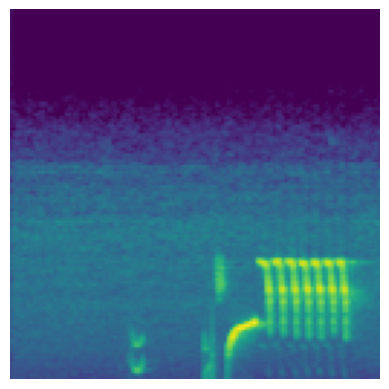

In [22]:
# Visualize a random sample
idx = random.randint(0, 1000)
im = np.array((tds[idx][0][0]+0.5).clip(0, 1)*255)
im = Image.fromarray(im.astype(np.uint8), mode='L')
a = mel.image_to_audio(im)
print(a.shape)
show_image(im)
display(Audio(a, rate=16000))

## **Setup Dataloaders**

In [23]:
bs = 32

def collate_ddpm(b): return noisify(default_collate(b)[0])

dls = DataLoaders(
    *get_dls(tds, vds, bs=bs, num_workers=fc.defaults.cpus, collate_fn=collate_ddpm)
)

In [25]:
batch = next(iter(dls.train))
batch[0][0].shape

torch.Size([32, 1, 128, 128])

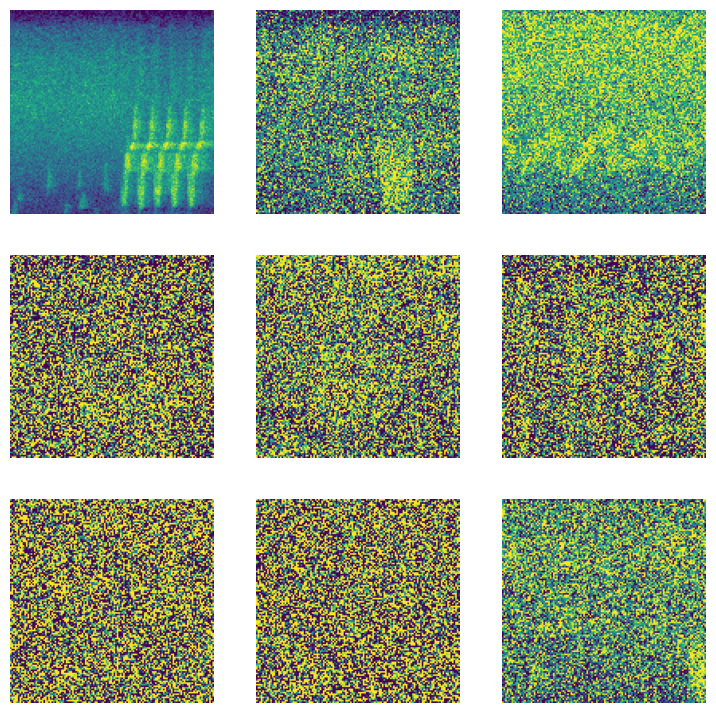

In [27]:
show_images(batch[0][0][:9].clip(-0.5, 0.5) + 0.5)

## **Setup Model**

The model's definition has been copied from https://github.com/fastai/course22p2/blob/master/nbs/30_lsun_diffusion-simple.ipynb

In [29]:
class LearnEmbSS(nn.Module):
  def __init__(self, sz, ni):
    super().__init__()
    self.scale = nn.Parameter(torch.zeros(sz, ni))
    self.shift = nn.Parameter(torch.zeros(sz, ni))

  def forward(self, x): return x*self.scale + self.shift

def _mlp(ni, nh):
  return nn.Sequential(nn.Linear(ni, nh), nn.GELU(), nn.LayerNorm(nh), nn.Linear(nh, ni))

class EmbTransformerBlk(nn.Module):
  def __init__(self, n_emb, ni, attn_chans=8):
    super().__init__()
    self.attn = SelfAttention(ni, attn_chans=attn_chans, transpose=False)
    self.mlp = _mlp(ni, ni*4)
    self.nrm1 = nn.LayerNorm(ni)
    self.nrm2 = nn.LayerNorm(ni)
    self.emb_proj = nn.Linear(n_emb, ni*2)

  def forward(self, x, t):
    emb = self.emb_proj(F.silu(t))[:, None]
    scale, shift = torch.chunk(emb, 2, dim=2)
    x = x + self.attn(self.nrm1(x))
    x = x * (1+scale) + shift
    return x + self.mlp(self.nrm2(x))

In [47]:
class SimpleDiffusion(nn.Module):
  def __init__(self, in_channels=3, out_channels=3, nfs=(224, 448, 672, 896), num_layers=1,
               attn_chans=8, attn_start=1, n_mids=8):
    super().__init__()
    self.conv_in = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
    self.n_temb = nf = nfs[0]
    n_emb = nf*4
    self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                 lin(n_emb, n_emb))
    self.downs = nn.ModuleList()
    n = len(nfs)
    for i in range(n):
      ni = nf
      nf = nfs[i]
      self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=n-1, num_layers=num_layers,
                                  attn_chans=0 if i < attn_start else attn_chans))
    self.le = LearnEmbSS(64, nf)
    # In Simple Diffusion, we want to concentrate the compute in the middle of UNet, which
    # is at a lower resolution and by utilizing transformers.
    self.mids = nn.ModuleList([EmbTransformerBlk(n_emb, nf) for _ in range(n_mids)])

    # Reversing and passing the features learned in the down blocks  to the up blocks
    rev_nfs = list(reversed(nfs))
    nf = rev_nfs[0]
    self.ups = nn.ModuleList()
    for i in range(n):
      prev_nf = nf
      nf = rev_nfs[i]
      ni = rev_nfs[min(i+1, len(nfs)-1)]
      self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=n-1, num_layers=num_layers+1,
                              attn_chans=0 if i>=n-attn_start else attn_chans))
    self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

  def forward(self, inp):
    x, t = inp
    temb = timestep_embedding(t, self.n_temb)
    emb = self.emb_mlp(temb)
    x = self.conv_in(x)
    saved = [x]
    for block in self.downs: x = block(x, emb)
    saved += [p for o in self.downs for p in o.saved]
    n, c, h, w = x.shape
    # Prepare to move through the transformer blocks by adding level embeddings
    x = self.le(x.reshape(n, c, -1).transpose(1, 2))
    for block in self.mids: x = block(x, emb)
    x = x.transpose(1, 2).reshape(n, c, h, w)
    for block in self.ups: x = block(x, emb, saved)
    return self.conv_out(x)

def init_ddpm(model):
    for o in model.downs:
      for p in o.resnets: p.conv2[-1].weight.data.zero_()

    for o in model.ups:
      for p in o.resnets: p.conv2[-1].weight.data.zero_()


## **Train Model**

In [48]:
lr = 1e-4
epochs = 20
opt_func = partial(optim.AdamW, eps=1e-5, weight_decay=1e-5)
tmax = epochs*len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), TrainCB()]
# This model is really flexible in how many features we want to generate and also the number of
# mid blocks that we want to stack
model = SimpleDiffusion(in_channels=1, out_channels=1, nfs=(16, 32, 256, 384, 512), num_layers=1,
                       attn_chans=0, n_mids=6) # Do additional nfs around mid-blocks improve output quality???
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.892,0,train
2.972,0,eval
0.494,1,train
0.335,1,eval
0.190,2,train
0.072,2,eval
0.067,3,train
0.070,3,eval
0.051,4,train
0.054,4,eval


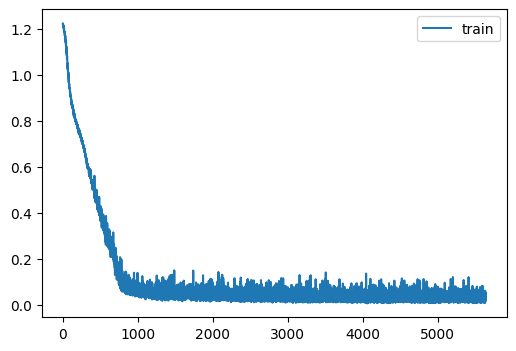

In [49]:
learn.fit(epochs)

## **Sampling**

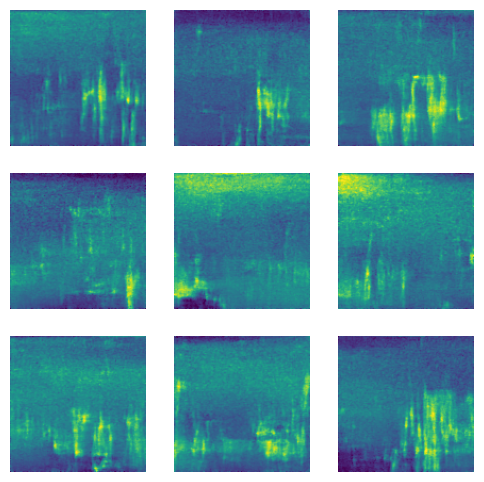

In [50]:
sz = (9, 1, x_res, y_res)

def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig, clamp=1.):
  sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
  x_0_hat = (x_t - (1-abar_t).sqrt()*noise) / abar_t.sqrt()
  if clamp: x_0_hat.clamp_(-clamp, clamp)
  if bbar_t1 <= sig**2 + 0.01 : sig=0.
  x_t = abar_t1.sqrt() * x_0_hat + (bbar_t1-sig**2).sqrt() * noise
  x_t += sig * torch.randn(x_t.shape).to(x_t)
  return x_0_hat, x_t

preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=1.)
s = (preds[-1] + 0.5)
s.min(), s.max(), s.shape
show_images(s[:9].clamp(0, 1), imsize=2)

(65024,)


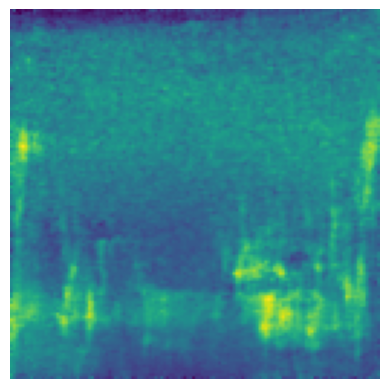

In [51]:
idx = 7
im = np.array((s[idx][0]).clip(0, 1)*255)
im = Image.fromarray(im.astype(np.uint8), mode='L')
a = mel.image_to_audio(im) # Convert the grey-scale image back to audio
print(a.shape)
show_image(im)
display(Audio(a, rate=16000))

Generate a single sample.

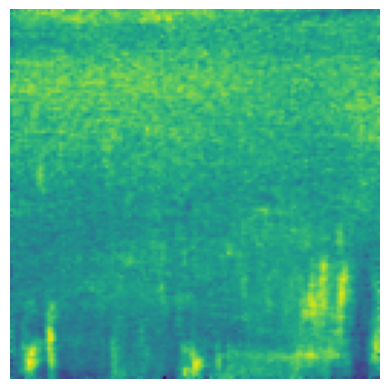

In [52]:
# Generate a single sample
sz = (1,1,x_res,y_res)
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=1.)
s = (preds[-1]+0.5)
im = np.array((s[0][0]).clip(0, 1)*255)
im = Image.fromarray(im.astype(np.uint8), mode='L')
a = mel.image_to_audio(im)
show_image(im)
display(Audio(a, rate=16000))

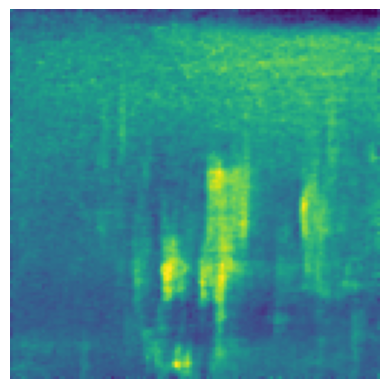

In [53]:
# Generate a single sample
sz = (1,1,x_res,y_res)
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=1.)
s = (preds[-1]+0.5)
im = np.array((s[0][0]).clip(0, 1)*255)
im = Image.fromarray(im.astype(np.uint8), mode='L')
a = mel.image_to_audio(im)
show_image(im)
display(Audio(a, rate=16000))

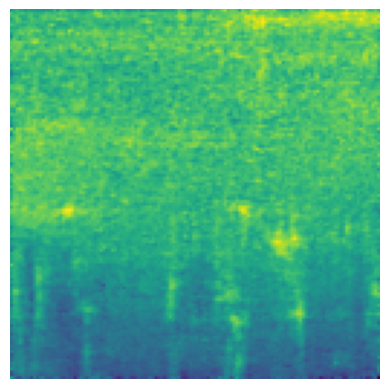

In [54]:
# Generate a single sample
sz = (1,1,x_res,y_res)
preds = sample(ddim_step, model, sz, steps=100, eta=1., clamp=1.)
s = (preds[-1]+0.5)
im = np.array((s[0][0]).clip(0, 1)*255)
im = Image.fromarray(im.astype(np.uint8), mode='L')
a = mel.image_to_audio(im)
show_image(im)
display(Audio(a, rate=16000))